### 12-1. 프로젝트: ControlNet으로 조건을 준 이미지 생성하기
지금까지는 Stable Diffusion 모델만을 이용하여 이미지를 생성하거나 이미지의 스타일을 바꾸는 실습을 해보았습니다. 이번에는 여기서 조금 더 나아가서 ControlNet을 사용하여 이미지에 조건을 주어 이미지를 다양하게 변형해보려고 합니다. 어떤 결과가 나올지 기대되지 않으시나요?  

#### ControlNet이란?
Stable Diffusion은 텍스트 프롬프트 또는 입력 이미지를 통하여 이미지를 생성하지만 생성된 이미지를 원하는 대로 출력하기 어렵습니다. 아무리 프롬프트를 자세하게 써도 생성되는 이미지가 내가 원하는 자세, 구도, 배경을 갖도록 하는 것은 거의 불가능하죠. ControlNet은 Diffusion 모델에 추가 조건을 추가하여 출력되는 이미지를 쉽게 제어할 수 있습니다. 뿐만 아니라 ControlNet은 훈련 데이터가 작아도 학습이 잘 되고 빠르다는 장점이 있어 개인용 기기에서 사용할 수 있다는 장점이 있습니다.  

ControlNet은 논문 'Adding Conditional Control to Text-to-Image Diffusion Models'에서 소개되었고, 외곽선 감지(Canny Edge detection), 인체 자세 감지(Human pose), 낙서 지도(Scribble map), 시맨틱 세그멘테이션(Semantic segmentation) 등 다양한 전처리기(Preprocessor)를 Stable Diffusion 모델에 도입할 수 있습니다. 그래서 원하는 자세, 구도 등으로 이미지를 생성할 수 있습니다.  
- 링크 : https://arxiv.org/abs/2302.05543
- 실습 관련 코드 : https://huggingface.co/docs/diffusers/v0.17.1/en/api/pipelines/stable_diffusion/overview


In [1]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 52.6 MB/s eta 0:00:00


In [5]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

In [ ]:
# Cuda out of memory 나오는 경우 사용할 코드
# 메모리 삭제
# torch.cuda.empty_cache()

In [6]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image
import cv2
from PIL import Image
import numpy as np
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers import UniPCMultistepScheduler
from controlnet_aux import OpenposeDetector

#### 윤곽선 검출
윤곽선을 검출해 봅시다. ControlNet은 다양한 윤곽선 검출 알고리즘을 제공하지만 우리는 가장 유명하고 효과적인 윤곽선 검출 알고리즘인 Canny 알고리즘을 사용할 거에요.  
- 관련 설명 : https://m.blog.naver.com/samsjang/220507996391
먼저 이미지를 불러옵니다. 누구나 익히 아는 이미지를 사용하였습니다.  

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

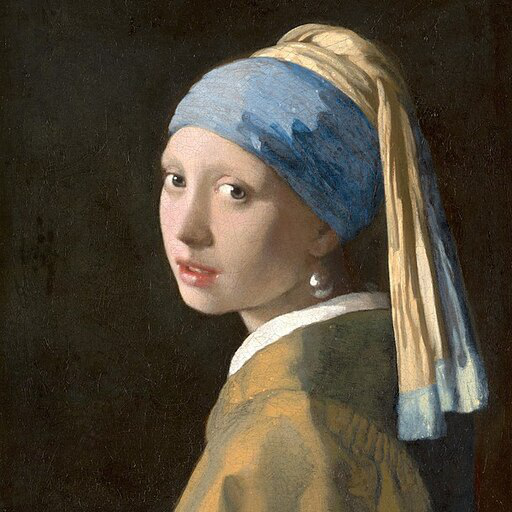

In [2]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

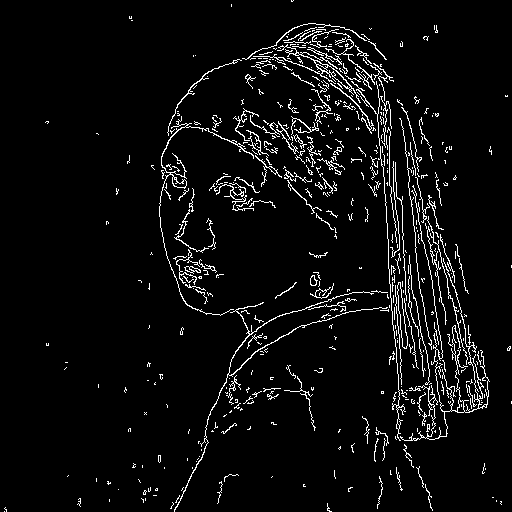

In [ ]:
# OpenCV를 사용하여 이미지의 윤곽선을 검출합니다.
import cv2
from PIL import Image
import numpy as np

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# threshold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다.

canny_image

In [ ]:
# diffusers 라이브러리에서 StableDiffusionControlNetPipeline과 ControlNetModel 클래스 가져오기
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

# Canny edge detection용 ControlNet 모델을 사전 학습된 가중치를 사용하여 불러옵니다.
# torch_dtype=torch.float16은 모델을 16비트 부동소수점 형식으로 로드하여 메모리 사용량을 줄이고 성능을 향상시킵니다.
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)

# Stable Diffusion 파이프라인에 ControlNet 모델을 통합합니다.
# Stable Diffusion 모델은 "runwayml/stable-diffusion-v1-5" 사전 학습된 체크포인트를 사용합니다.
# ControlNet 모델을 controlnet 매개변수에 전달하여 이미지 생성에 제어를 추가합니다.
# torch_dtype=torch.float16을 사용하여 메모리 효율성을 유지합니다.
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

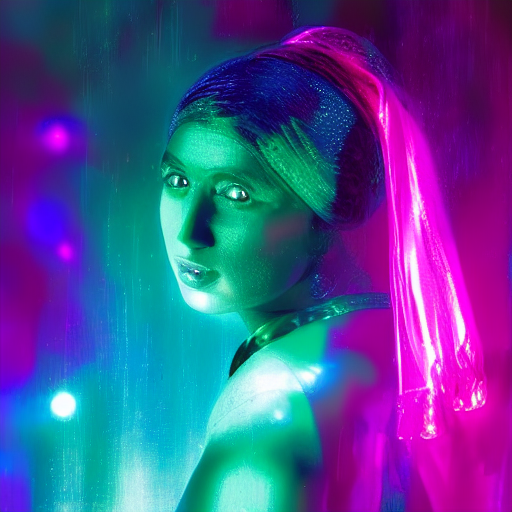

In [ ]:
# UniPCMultistepScheduler를 사용하여 샘플링 스케줄러를 변경합니다.
# UniPCMultistepScheduler는 더 빠르고 안정적인 추론을 가능하게 합니다.
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)

# 파이프라인을 CUDA 장치(GPU)로 옮겨 빠른 추론이 가능하도록 설정합니다.
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 난수 생성기의 seed를 고정합니다.
# seed 값을 고정하면 항상 동일한 조건에서 동일한 결과를 얻을 수 있습니다.
generator = torch.manual_seed(0)

# Stable Diffusion 파이프라인을 사용하여 이미지를 생성합니다.
# - prompt: 생성할 이미지에 대한 텍스트 설명입니다. 여기서는 "disco dancer with colorful lights"라는 설명을 사용합니다.
# - num_inference_steps: 이미지 생성 과정에서의 추론 단계 수를 지정합니다. 단계 수가 많을수록 품질은 좋아지지만 속도는 느려집니다.
# - generator: 고정된 난수 생성기를 사용하여 재현 가능한 결과를 보장합니다.
# - image: 윤곽선이 포함된 입력 이미지를 전달하여 이를 기반으로 이미지를 생성합니다.
canny_image2 = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 로컬 경로에 저장합니다.
canny_image2.save("/content/canny_image2.png")

# 생성된 이미지를 출력하여 결과를 확인합니다.
canny_image2


프롬프트 외에도 부정적인 프롬프트(negative_propmt)를 넣을 수도 있고, 하이퍼파라미터를 조절할 수도 있습니다.  

- negative_propmt: 원하지 않는 요소를 적을 수 있습니다.
- controlnet_conditioning_scale: ContorlNet으로 조건을 어느 정도 주느냐를 조절합니다. Default는 1이고, 실수값으로 설정할 수 있습니다.
- num_inference_steps: 추론 횟수로, 값이 커질수록 고해상도 이미지가 출력되지만 출력되는 시간이 오래 걸립니다. default 값은 50입니다.
- guidance_scale: 얼마나 주어진 프롬프트에 근접한 이미지를 생성할지를 설정하는 하이퍼파라미터로, 값이 커질수록 문자열에 근접한 이미지가 생성되지만 이미지 품질이 떨어질 수 있습니다. default는 7.5입니다.

  0%|          | 0/30 [00:00<?, ?it/s]

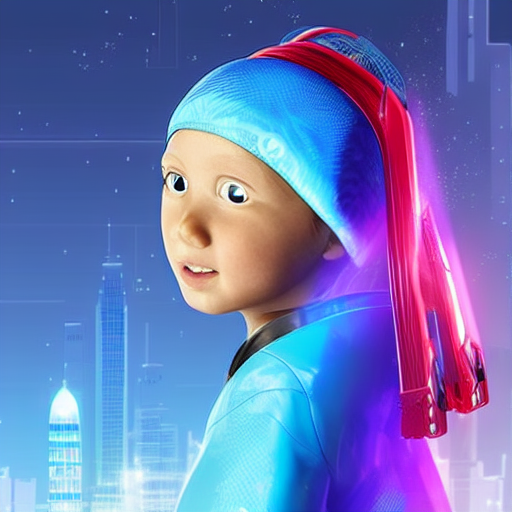

In [ ]:
from diffusers import UniPCMultistepScheduler

# 파이프라인의 스케줄러를 UniPCMultistepScheduler로 설정
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)

# 파이프라인을 GPU(CUDA)로 이동
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 재현하기 위해 seed 값을 설정
generator = torch.manual_seed(0)

# 이미지 생성에 사용할 하이퍼파라미터를 설정할 수 있도록 코드 작성
def generate_image(
    prompt="disco dancer with colorful lights",  # 생성할 이미지에 대한 텍스트 설명
    negative_prompt=None,  # 생성하지 않기를 원하는 내용 (기본값 없음)
    num_inference_steps=20,  # 이미지 생성 추론 단계 수 (기본값 20)
    guidance_scale=7.5,  # 텍스트 가이던스 강도 (기본값 7.5)
    controlnet_conditioning_scale=1.0  # ControlNet의 영향도 설정 (기본값 1.0)
):
    """
    Stable Diffusion 모델을 사용하여 이미지를 생성하는 함수.

    Args:
        prompt (str): 생성할 이미지에 대한 텍스트 설명.
        negative_prompt (str): 생성하지 않기를 원하는 이미지의 텍스트 설명.
        num_inference_steps (int): 이미지 생성 추론 단계 수.
        guidance_scale (float): 텍스트 가이던스 강도.
        controlnet_conditioning_scale (float): ControlNet 영향도.

    Returns:
        PIL.Image.Image: 생성된 이미지.
    """
    # Stable Diffusion 파이프라인을 사용하여 이미지 생성
    result = canny_pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        generator=generator,
        image=canny_image
    )
    # 결과 이미지 반환
    return result.images[0]

# 예제: 하이퍼파라미터를 설정하여 이미지 생성
generated_image = generate_image(
    prompt="a futuristic cityscape with flying cars",
    negative_prompt="dark and gloomy, woman",
    num_inference_steps=30,
    guidance_scale=8.0,
    controlnet_conditioning_scale=0.8
)

# 생성된 이미지를 저장
generated_image.save("/content/generated_image1.png")

# 생성된 이미지를 출력
generated_image


#### 인체 자세 감지
Openpose는 인체 자세 감지(Human pose)를 할 수 있는 전처리기입니다. 자세를 감지하여 새로운 이미지를 생성해 줍니다.  

먼저 사람의 전신이 담긴 이미지를 불러오겠습니다.  

In [ ]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

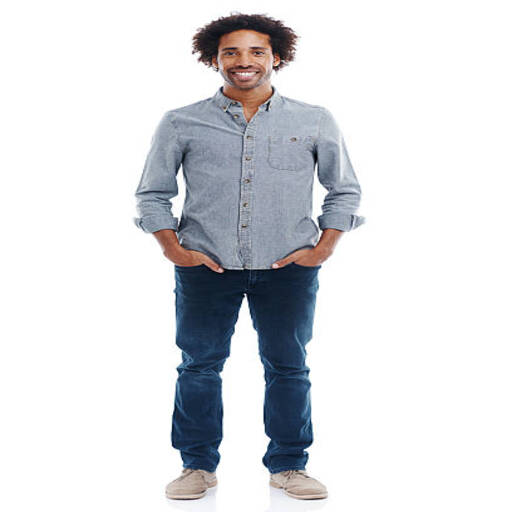

In [3]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

cuda


/usr/local/lib/python3.10/dist-packages/controlnet_aux/open_pose/body.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load(

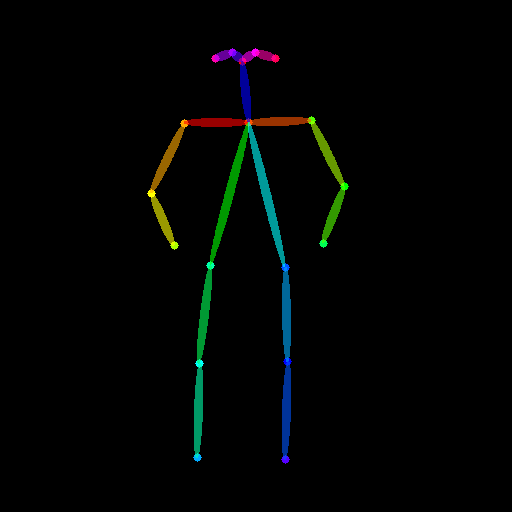

In [ ]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

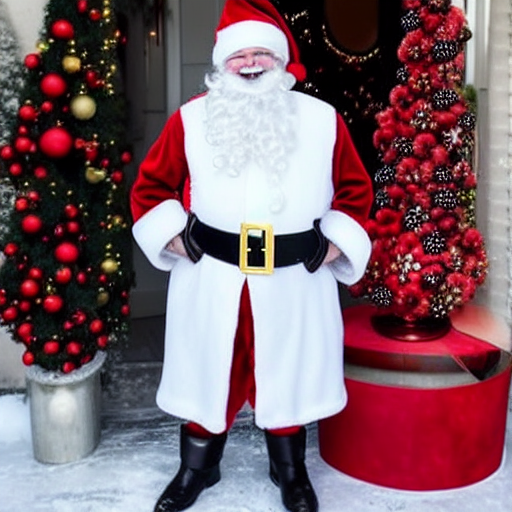

In [ ]:
# UniPCMultistepScheduler를 사용하여 샘플링 스케줄러를 변경합니다.
# UniPCMultistepScheduler는 더 빠르고 안정적인 추론을 가능하게 합니다.
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)

# 파이프라인을 CUDA 장치(GPU)로 옮겨 빠른 추론이 가능하도록 설정합니다.
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 난수 생성기의 seed를 고정합니다.
# seed 값을 고정하면 항상 동일한 조건에서 동일한 결과를 얻을 수 있습니다.
generator = torch.manual_seed(0)

#프롬프트를 작성합니다.
prompt =  "Santa Claus smiling happily while wearing Santa suit"
negative_prompt =  "Angry"

# OpenPose 이미지를 기반으로 이미지를 생성합니다.
# prompt와 negative_prompt를 사용하여 텍스트 기반으로 이미지를 생성합니다.
result = openpose_pipe(
    prompt=prompt,                 # 생성할 이미지에 대한 설명
    negative_prompt=negative_prompt,  # 생성하지 않을 요소에 대한 설명
    num_inference_steps=30,        # 추론 단계 수를 설정 (기본값을 조정 가능)
    guidance_scale=7.5,            # 텍스트 가이던스 강도 설정 (기본값을 조정 가능)
    generator=generator,           # 고정된 난수 생성기를 사용하여 재현성을 보장
    image=images                   # OpenPose 기반 이미지 입력
)

# 결과에서 생성된 첫 번째 이미지를 가져옵니다.
generated_image3 = result.images[0]

# 생성된 이미지를 저장합니다.
generated_image3.save("/content/santa.png")

# 생성된 이미지를 출력합니다.
generated_image3


  0%|          | 0/40 [00:00<?, ?it/s]

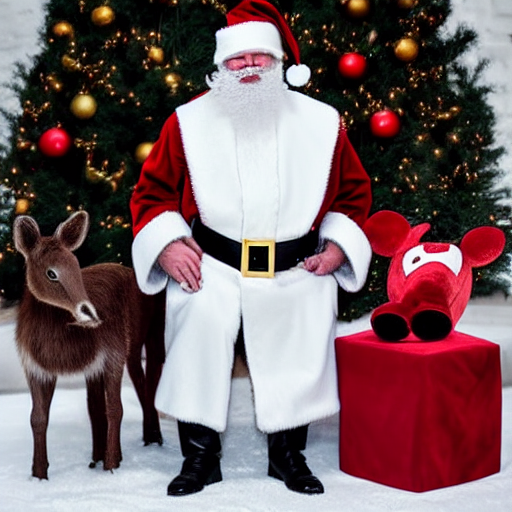

In [ ]:
# UniPCMultistepScheduler를 사용하여 샘플링 스케줄러를 변경합니다.
from diffusers import UniPCMultistepScheduler

# 스케줄러 설정
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)

# 파이프라인을 CUDA 장치(GPU)로 옮깁니다.
openpose_pipe = openpose_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 고정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성하는 함수
def generate_openpose_image(
    prompt="Santa Claus smiling happily while wearing Santa suit",  # 기본 프롬프트
    negative_prompt="Angry",  # 기본 네거티브 프롬프트
    num_inference_steps=30,  # 추론 단계 수 (기본값 30)
    guidance_scale=7.5,  # 텍스트 가이던스 강도 (기본값 7.5)
    controlnet_conditioning_scale=1.0  # ControlNet 영향도 (기본값 1.0)
):
    """
    OpenPose 기반으로 Stable Diffusion 모델을 사용하여 이미지를 생성합니다.

    Args:
        prompt (str): 생성할 이미지에 대한 텍스트 설명.
        negative_prompt (str): 생성하지 않기를 원하는 이미지 요소.
        num_inference_steps (int): 이미지 생성 과정에서의 추론 단계 수.
        guidance_scale (float): 텍스트 가이던스 강도.
        controlnet_conditioning_scale (float): ControlNet 영향도.

    Returns:
        PIL.Image.Image: 생성된 이미지.
    """
    # Stable Diffusion 파이프라인을 사용해 이미지를 생성
    result = openpose_pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        generator=generator,
        image=images  # OpenPose 입력 이미지
    )
    # 생성된 첫 번째 이미지 반환
    return result.images[0]

# 함수 호출로 이미지 생성
generated_image = generate_openpose_image(
    prompt="Santa looking at baby rudolph",  # 원하는 프롬프트
    negative_prompt="sunny",  # 네거티브 프롬프트
    num_inference_steps=40,  # 추론 단계 수 조정
    guidance_scale=8.0,  # 텍스트 가이던스 강도 조정
    controlnet_conditioning_scale=0.9  # ControlNet 영향도 조정
)

# 생성된 이미지를 저장합니다.
generated_image.save("/content/santa_custom.png")

# 생성된 이미지를 출력합니다.
generated_image


#### 윤곽선 검출 + 인체 자세 감지
이번에는 위에서 실습한 2가지의 전처리기를 동시에 사용해 보겠습니다. 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달하면 됩니다.  

##### Canny 알고리즘을 사용한 윤곽선 검출
먼저 Canny 알고리즘으로 윤곽선을 검출합니다. Canny 알고리즘으로 윤곽선을 검출한 이미지 위에 인체 자세 검출 전처리기를 올려줄 것이기 때문에 인체 자세를 넣어줄 부분을 이미지 내에서 지워주어야 한다는 점을 주의하세요.  

직접 아래의 코드를 작성해 보세요.  

In [7]:
from diffusers.utils import load_image  # 이미지를 로드하기 위한 유틸리티 함수
from PIL import Image  # PIL 라이브러리로 이미지 처리
import cv2  # OpenCV 라이브러리로 이미지 처리
import numpy as np  # NumPy 배열 작업

# 이미지를 불러오세요.
# diffusers의 load_image를 사용하여 URL 또는 파일 경로에서 이미지를 불러옵니다.
canny_image = load_image("/content/IMG.jpeg")  # 이미지 URL 또는 로컬 경로를 입력하세요.

# 이미지를 Grayscale로 변환합니다.
canny_image = cv2.cvtColor(np.array(canny_image), cv2.COLOR_RGB2GRAY)

# Canny edge detection을 위한 threshold를 지정합니다.
low_threshold = 50  # 낮은 threshold 값
high_threshold = 150  # 높은 threshold 값

# Canny 알고리즘을 적용하여 윤곽선을 검출합니다.
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)

# 이미지를 NumPy 배열로 변환합니다.
# (이미 Canny 알고리즘을 거치면 NumPy 배열 형태로 변환됩니다.)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다.
# 이미지 가운데를 비웁니다.
zero_start = canny_image.shape[1] // 4  # 이미지 가로 크기의 1/4 지점
zero_end = zero_start + canny_image.shape[1] // 2  # 가운데 절반을 비움
canny_image[:, zero_start:zero_end] = 0  # 가운데 부분을 0으로 설정

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다.
# 1. NumPy 배열을 RGB로 변환합니다.
canny_image = cv2.cvtColor(canny_image, cv2.COLOR_GRAY2RGB)

# 2. NumPy 배열을 PIL 이미지로 변환합니다.
canny_image = Image.fromarray(canny_image)

# 3. PIL 이미지를 저장하거나 출력합니다.
canny_image.show()  # 이미지 보기 (옵션)
canny_image.save("canny_pose_image.png")  # 로컬에 저장


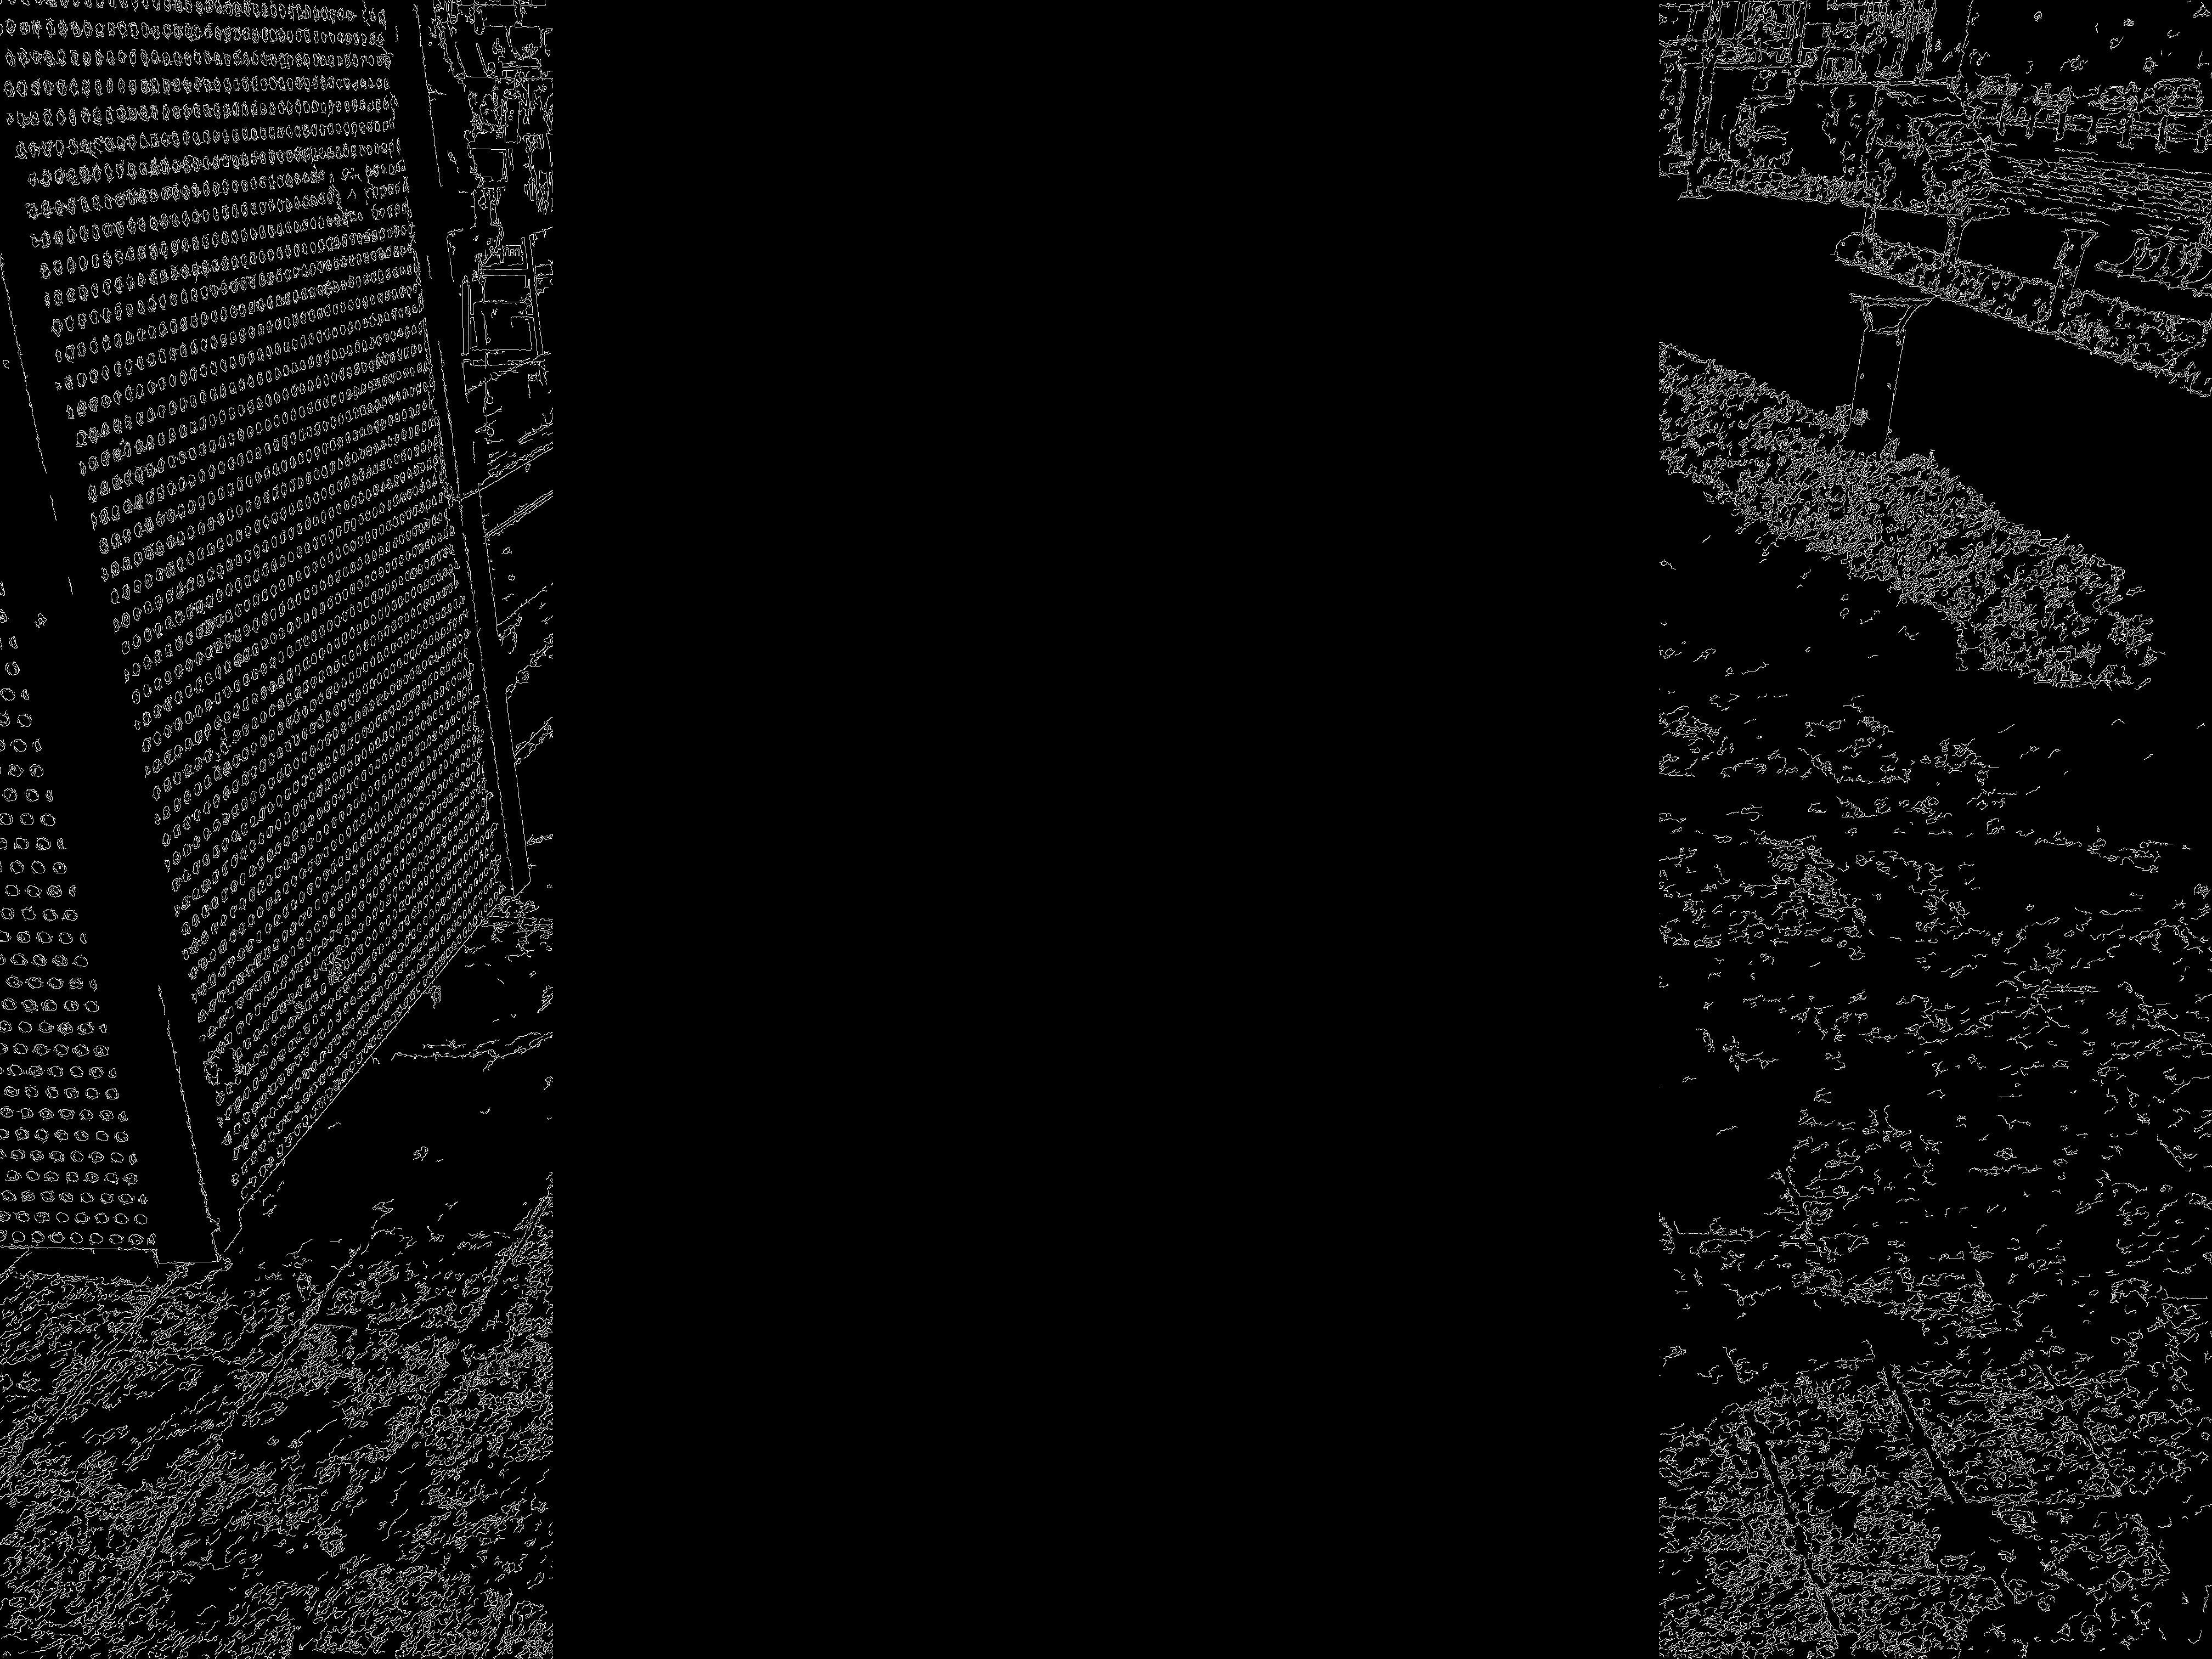

In [8]:
from IPython.display import Image, display

# 저장된 이미지 경로
image_path = "/content/canny_pose_image.png"

# 이미지를 Colab 창에서 표시
display(Image(filename=image_path))


In [9]:
from controlnet_aux import OpenposeDetector  # OpenposeDetector를 가져옵니다.
from diffusers.utils import load_image  # 이미지를 로드하기 위한 함수
from PIL import Image  # PIL 라이브러리로 이미지 처리
import numpy as np  # NumPy 라이브러리

# 이미지를 불러옵니다.
# 로컬 경로에 있는 이미지를 불러옵니다.
openpose_image = load_image("/content/IMG.jpeg")  # 로컬 파일 경로 입력

# OpenposeDetector를 초기화합니다.
# 디폴트 설정으로 OpenposeDetector를 사용합니다.
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# OpenposeDetector를 사용하여 인체 자세를 검출합니다.
# OpenposeDetector는 PIL 이미지를 입력받아 NumPy 배열 형태로 결과를 반환합니다.
openpose_image = openpose(openpose_image)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

cuda


/usr/local/lib/python3.10/dist-packages/controlnet_aux/open_pose/body.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load(

In [10]:
# # Cuda out of memory 나오는 경우 사용할 코드
# # 메모리 삭제
# torch.cuda.empty_cache()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

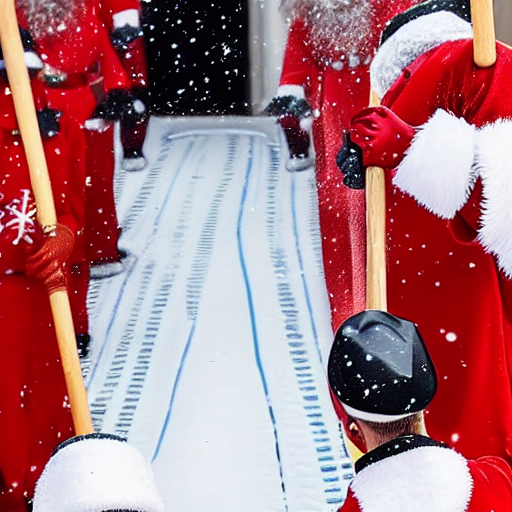

In [12]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import torch
import torchvision.transforms as transforms

# Edge Detection과 Openpose, 2개의 전처리기를 ControlNet 모델로 만듭니다.
controlnets = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16),  # Canny Edge Detection
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)  # Openpose
]

# Stable Diffusion 모델에 두 개의 ControlNet을 통합합니다.
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",  # Stable Diffusion 모델 체크포인트
    controlnet=controlnets,  # 여러 ControlNet 모델 전달
    torch_dtype=torch.float16  # 메모리 효율성을 위한 16비트 설정
)

# 스케줄러 설정
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# 파이프라인을 CUDA 장치로 이동
pipe = pipe.to("cuda")

# 프롬프트와 네거티브 프롬프트 작성
prompt = "Santa Claus with a broom sweeping the floor on a snowy day"
negative_prompt = "dark and gloomy"

# 동일한 이미지를 생성하기 위해 seed 설정
generator = torch.manual_seed(42)

# 두 개의 입력 이미지를 동일한 크기로 변환합니다.
# 기준 크기를 설정합니다 (512x512 권장)
resize_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # 512x512로 크기 조정
    transforms.ToTensor()  # 텐서로 변환
])

# OpenposeDetector와 Canny 결과 이미지를 크기 조정
openpose_image_resized = resize_transform(openpose_image)
canny_image_resized = resize_transform(canny_image)

# 두 이미지를 다시 PIL 이미지로 변환
openpose_image_resized = transforms.ToPILImage()(openpose_image_resized)
canny_image_resized = transforms.ToPILImage()(canny_image_resized)

# 두 전처리기로부터 얻은 이미지를 리스트로 만듭니다.
images = [openpose_image_resized, canny_image_resized]

# 이미지를 생성합니다.
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    generator=generator,
    image=images
).images[0]

# 생성된 이미지를 저장합니다.
image.save("/content/multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.
image
